In [6]:
import os
import sys
import json
import time as tl
from math import (exp, log)

import msprime
import numpy as np
# import torch

RHO_LIMIT = (1.6*10e-8, 1.6*10e-10)
MU_LIMIT = (1.25*10e-9, 1.25*10e-7)

LENGTH_NORMALIZE_CONST = 4
ZIPPED = False
NUMBER_OF_EVENTS_LIMITS = (1, 20)
MAX_T_LIMITS = (0.01, 50)
LAMBDA_EXP = 1000
POPULATION_LIMITS = (250, 100000)
POPULATION = 5000

N = 20

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


L_HUMAN = 3_000_000
RHO_HUMAN = 1.6*10e-9
MU_HUMAN = 1.25*10e-8

RHO_LIMIT = (1.6*10e-10, 1.6*10e-8)
MU_LIMIT = (1.25*10e-7, 1.25*10e-9)

NUMBER_OF_EVENTS_LIMITS = (1, 20)
LAMBDA_EXP = 20_000

POPULATION = 10_000
POPULATION_COEFF_LIMITS = (0.5, 1.5)
MIN_POPULATION_NUM = 1_000


def give_rho() -> float:
    return np.random.uniform(*RHO_LIMIT)


def give_mu() -> float:
    return np.random.uniform(*MU_LIMIT)


def give_random_coeff(mean=.128, var=.05) -> float:
    return np.random.beta(.1, .028)*.0128


def give_random_rho(base=RHO_HUMAN) -> float:
    return np.random.uniform(0.0001, 100, 1)[0]*base


def generate_demographic_events(population: int = POPULATION) -> 'msprime.Demography':
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=population)

    number_of_events = np.random.randint(*NUMBER_OF_EVENTS_LIMITS)

    times = sorted(np.random.exponential(LAMBDA_EXP, size=number_of_events))

    last_population_size = population
    for t in times:
        last_population_size = max(last_population_size * np.random.uniform(*POPULATION_COEFF_LIMITS),
                                   MIN_POPULATION_NUM)
        demography.add_population_parameters_change(
            t, initial_size=last_population_size)

    return demography


class arg:
    population = 5000.0
    rho = RHO_HUMAN
    mu = MU_HUMAN
    # num_repl = 1
    # l = 300
    num_repl = 1
    lengt = L_HUMAN
    ratio_train_examples = 0.9
    random_seed = 142
    model = "hudson"
    sample_size = 2
    demographic_events = generate_demographic_events()


def simple_split(time: float, N: int, split_const: int = 5000) -> int:
    return int(min(time//split_const, N-1))


class DataGenerator():
    def __init__(self,
                 recombination_rate: float = RHO_HUMAN,
                 mutation_rate: float = MU_HUMAN,
                 demographic_events: list = None,
                 population: int = None,
                 number_intervals: int = N,
                 splitter=simple_split,  # maust be annotiede
                 num_replicates: int = 1,
                 lengt: int = L_HUMAN,
                 model: str = "hudson",
                 random_seed: int = 42,
                 sample_size: int = 1,
                 ):

        self.sample_size = sample_size
        self.recombination_rate = recombination_rate
        self.mutation_rate = mutation_rate
        self.num_replicates = num_replicates
        if not demographic_events:
            if not population:
                raise BaseException(
                    "Eiter demographic_events or population must be speciefied")
            demographic_events = msprime.Demography()
            demographic_events.add_population(
                name="A", initial_size=population)
        self.demographic_events = demographic_events
        self.splitter = splitter
        self.model = model
        self.len = lengt
        self.random_seed = random_seed
        self.number_intervals = number_intervals
        self._data = None

    def run_simulation(self):
        """
        return generator(tskit.TreeSequence)
        function run the simulation with given parametrs
        """
        self._data = msprime.sim_ancestry(
            recombination_rate=self.recombination_rate,
            sequence_length=self.len,
            num_replicates=self.num_replicates,
            demography=self.demographic_events,
            model=self.model,
            random_seed=self.random_seed,
            samples=self.sample_size)
        return self._data

    def __iter__(self):
        return self

    def __next__(self):
        """
        return haplotype, recombination points and coalescent time
        """
        if self._data is None:
            self.run_simulation()

        try:
            tree = next(self._data)
        except StopIteration:
            raise StopIteration

        mutated_ts = msprime.sim_mutations(
            tree, rate=self.mutation_rate)  # random_seed

        times = [0]*self.len
        mutations = [0]*self.len
        prior_dist = [0.0]*self.number_intervals

        for m in mutated_ts.mutations():
            mutations[int(m.position)] = 1

        for t in mutated_ts.aslist():
            interval = t.get_interval()
            left = interval.left
            right = interval.right
            time = t.get_total_branch_length()/2
            times[int(left):int(right)] = [time]*int(right-left)
            prior_dist[self.splitter(
                time, self.number_intervals)] += (int(right-left))/self.len

        return mutations, times, prior_dist

In [9]:
dem = generate_demographic_events()

In [16]:
dem

Demography(populations=[Population(initial_size=10000, growth_rate=0, name='A', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0)], events=[PopulationParametersChange(time=466.65047196646776, initial_size=11803.075385877797, growth_rate=None, population=-1), PopulationParametersChange(time=955.7922252754352, initial_size=11218.81432521697, growth_rate=None, population=-1), PopulationParametersChange(time=1899.5462639332889, initial_size=5758.224298892243, growth_rate=None, population=-1), PopulationParametersChange(time=5299.408001000487, initial_size=8304.521193489572, growth_rate=None, population=-1), PopulationParametersChange(time=9640.293195410071, initial_size=8830.09953988604, growth_rate=None, population=-1), PopulationParametersChange(time=10211.878735991624, initial_size=7818.31585168522, growth_rate=None, population=-1), PopulationParametersChange(time=12575.78201081712, initial_size=4033.987128667915, growth_rate=None, population=-1), PopulationParametersChange(time=14879.323759666378, initial_size=2948.4162849826007, growth_rate=None, population=-1), PopulationParametersChange(time=19266.91353813664, initial_size=2184.8515516179136, growth_rate=None, population=-1), PopulationParametersChange(time=39313.745615476735, initial_size=2585.255135078675, growth_rate=None, population=-1), PopulationParametersChange(time=72805.9910725552, initial_size=2869.6245594526877, growth_rate=None, population=-1), PopulationParametersChange(time=81764.33050919391, initial_size=3825.7688612554552, growth_rate=None, population=-1)], migration_matrix=array([[0.]]))

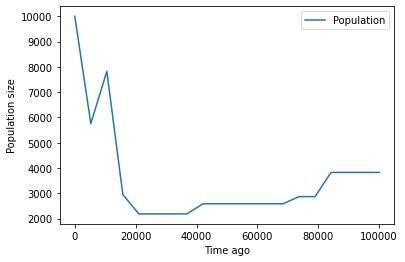

In [15]:
import matplotlib.pyplot as plt

debug = dem.debug()

t = np.linspace(0, 100_000, num=20)
S = debug.population_size_trajectory(t)
plt.plot(t, S, label="Population")
plt.xlabel("Time ago")
plt.ylabel("Population size")
plt.legend();

In [18]:
num_model = 1
x_path = os.path.join("val_data", "x")
y_path = os.path.join("val_data", "y")
pd_path = os.path.join("val_data", "PD")

name = 1
print(f'Path: {sys.argv[1]}')
print(f"Num_model: {num_model}")
print(f"Num replicates: {sys.argv[2]}")
for j in range(num_model):
    generator = DataGenerator(
        demographic_events=dem,
        num_replicates=1
    )
    generator.run_simulation()
    # return mutations, times, None, prior_dist, None
    for x, y, t in generator:
        print(name)
        x = np.array(x, dtype=np.int64)
        y = np.array(y)
        pd = np.array(t)

        np.save(x_path + "/" + str(name), x)
        np.save(y_path + "/" + str(name), y)
        np.save(pd_path + "/" + str(name), pd)
        name += 1

Path: -f
Num_model: 1
Num replicates: /Users/evgen97/Library/Jupyter/runtime/kernel-f7af6c8a-23ea-428a-8728-06bdab89c58d.json
0


In [19]:
for j in range(num_model):
    generator = DataGenerator(
        demographic_events=dem,
        num_replicates=1
    )
    generator.run_simulation()
    # return mutations, times, None, prior_dist, None
    for x, y, t in generator:
        print(name)
        x = np.array(x, dtype=np.int64)
        y = np.array(y)
        pd = np.array(t)
        name += 1

1


In [21]:
len(pd)

20

$
T = e^{ct} \\
ct = \log{T} \\
c = \frac{\log{T_{max}}}{N-1}
$

# Новая разбивка

In [106]:
T_max = 400_000
N = 20
coeff = np.log(T_max)/(N-1)

limits = [np.exp(coeff*i) for i in range(N)]

print(limits)

def exponent_split(time: float, N: int) -> int:
    for i, limit in enumerate(limits):
        if limit > time:
            return i
    return N-1 

[1.0, 1.97172009536563, 3.8876801344686487, 7.665417045485589, 15.114056827942171, 29.800689570151686, 58.75861848122102, 115.85554883534577, 228.43471379826536, 450.40931567513616, 888.0810988565476, 1751.0473489298454, 3452.575245821688, 6807.511992948546, 13422.508195939188, 26465.429140143187, 52182.418468095406, 102889.12311832218, 202868.55164694443, 400000.0000000009]


In [102]:
a = [exponent_split(t, 20) for t in range(420_000)]

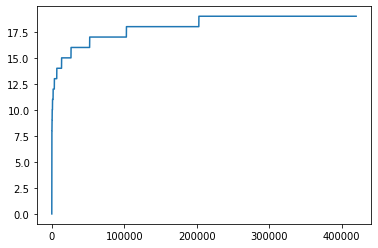

In [105]:
plt.plot([t for t in range(420_000)], a)

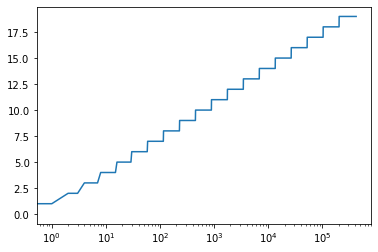

In [104]:
plt.plot([t for t in range(420_000)], a)
plt.xscale("log")

In [85]:
for i in range(N):
    print(np.exp(coeff*i))

1.0
1.97172009536563
3.8876801344686487
7.665417045485589
15.114056827942171
29.800689570151686
58.75861848122102
115.85554883534577
228.43471379826536
450.40931567513616
888.0810988565476
1751.0473489298454
3452.575245821688
6807.511992948546
13422.508195939188
26465.429140143187
52182.418468095406
102889.12311832218
202868.55164694443
400000.0000000009


## Новый генератор

In [162]:
lambda_exp = 1_000
coal_limits = 0.999999999

def generate_demographic_events_complex(population: int = POPULATION) -> 'msprime.Demography':
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=population)

    last_population_size = population
    T = 0
    coal_probability = 0.0
    while coal_probability < coal_limits:

        t = np.random.exponential(lambda_exp)
        T += t
        
        last_population_size = max(last_population_size * np.random.uniform(*POPULATION_COEFF_LIMITS),
                                   MIN_POPULATION_NUM)

        demography.add_population_parameters_change(
            T, initial_size=last_population_size)
        if coal_probability == 0.0:
            coal_probability = (1-np.exp(-t/last_population_size))
        else:
            coal_probability += coal_limits*(1- np.exp(-t/last_population_size))    
    return demography

In [169]:
dm = generate_demographic_events_complex()
dm

Demography(populations=[Population(initial_size=10000, growth_rate=0, name='A', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0)], events=[PopulationParametersChange(time=933.3199275787193, initial_size=6232.339460298239, growth_rate=None, population=-1), PopulationParametersChange(time=2570.9655663655844, initial_size=3985.9503332475247, growth_rate=None, population=-1), PopulationParametersChange(time=3089.4996264055935, initial_size=2168.1296774409334, growth_rate=None, population=-1), PopulationParametersChange(time=3137.7185637677526, initial_size=2631.5845069195307, growth_rate=None, population=-1), PopulationParametersChange(time=3272.90815093749, initial_size=2232.573484999948, growth_rate=None, population=-1), PopulationParametersChange(time=3329.6041059635027, initial_size=3252.8381337391793, growth_rate=None, population=-1), PopulationParametersChange(time=3591.891635008727, initial_size=3299.126977841448, growth_rate=None, population=-1), PopulationParametersChange(time=4737.84513585389, initial_size=3846.478323330984, growth_rate=None, population=-1)], migration_matrix=array([[0.]]))

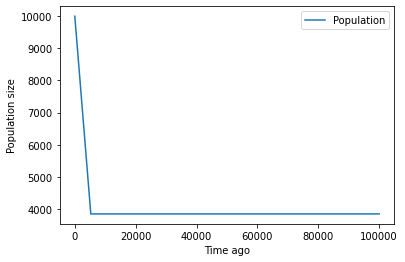

In [170]:
debug = dm.debug()

t = np.linspace(0, 100_000, num=20)
S = debug.population_size_trajectory(t)
plt.plot(t, S, label="Population")
plt.xlabel("Time ago")
plt.ylabel("Population size")
plt.legend();